In [2]:
import random
import json
import re
import os
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

random.seed(6)
np.random.seed(6)

WORK_DIR = Path.cwd().parent.parent


# Experiment ? - Llama3.2 3b on chat mode

In this experiment I feed the the model a revisioned version of the input, where the STSG is put the beginning of the prompt and the question with the alternatives at the end. Finally I ask the model to reason about the possible answer *step by step*, conditioning it to perform Zero-Shot-CoT (Prompt engineering technique where no example of thow to perform the reasoning is provided -- no in-context learning). Moreover, instead of asking the model to provide the answer on the same promtp, I instatied the model in multi-turn chat mode where, after the model gives the first response, a script sends an automatic reply asking to extract the final answer given by the model and give it a json format.

**Parameters:**
- model: Gemma3 12b
- system prompt: MCQ_system_promtp_ZS_CoT.txt
- user_prompt: MCQ_user_prompt_ZS_CoT_v2.txt
- temperature: 0.1
- sampling method: (default) top-p (p=0.9)


## Prompts

In [3]:
with open(WORK_DIR / 'data/prompts/zero-shot-cot/MCQ_system_prompt_ZS_CoT.txt', 'r') as f:
    pr = f.read()

print(pr)


You need to respond to reasoning questions by making logical inference on sequence of Scene-Graphs extracted from frames belonging to a video, called a Spatio-Temporal Scene Graph.

IMPORTANT CLARIFICATIONS:
- You will receive a question and Spatio-Temporal Scene-Graph
- Each Scene-Graph is a static symbolic representation of the scene unfolding in the frame
- The Scene-Graphs are ordered chronologically
- The Scene-Graph is represented as a set of tuple in the format: subject - relationship - object
- The Spatio-Temporal Scene-Graph is a cornologically sorted list of Scene-Graphs

INSTRUCTIONS:
- Read the entire Spatio-Temporal Scene-Graphs in chronological order and pay attention at the order of how events unfold.
- Read the question and reason about the answer step by step.
- In your answer include key events or relationships that help you in determing the correct answer.
- Be careful to reproduce the chosen alternative as it is presented.


In [4]:
with open(WORK_DIR / 'data/prompts/zero-shot-cot/MCQ_user_prompt_ZS_CoT_v2.txt', 'r') as f:
    pr = f.read()

print(pr)


Please carefully read the following Spatio-Temporal Scene Graph delimited by the <STSG> tags and provide an answer to the question below:

<STSG>
{stsg}
</STSG>

Given the following question:
<Q>
{question}
<Q>

And the following alternatives:
<Alternatives>
A. {c1}
B. {c2}
C. {c3}
D. {c4}
</Alternatives>

Provide an answer to the above question reasoning step by step on the Spatio-Temporal Scene-Graph (STSG) and choosing one of the alternatives.


In [5]:
reply = """\
Therefore the final answer is?

Your response must be provided in valid JSON format as follows:
{"answer": "your complete answer here"}

IMPORTANT: Always include both the letter (A, B, C, D, etc.) AND the full text of the answer in your response.
Do not abbreviate or shorten the answer. For example, if the correct answer is "A. the laptop", your response 
should be {"answer": "A. the laptop"}, not {"answer": "laptop"} or {"answer": "A"}.\
"""

print(reply)


Therefore the final answer is?

Your response must be provided in valid JSON format as follows:
{"answer": "your complete answer here"}

IMPORTANT: Always include both the letter (A, B, C, D, etc.) AND the full text of the answer in your response.
Do not abbreviate or shorten the answer. For example, if the correct answer is "A. the laptop", your response 
should be {"answer": "A. the laptop"}, not {"answer": "laptop"} or {"answer": "A"}.


Let's load the ground truth from the `STAR_QA_question_and_stsg_val.json` file where we extracted QA and spatio-temporal scene graphs

In [6]:
ground_truth = []

with open(WORK_DIR / 'data/datasets/STAR_QA_and_stsg_val.json') as f:
    data = json.load(f)
    ground_truth = [{
        'id': sample['question_id'],
        'question': sample['question'],
        'choices': sample['choices'],
        'num': sample['answer'],
        'text': sample['choices'][str(sample['answer'])],
        'stsg': sample['stsg'],
    } for sample in data]


# we keep num as str so we can directrly access choices dictionaries
gt_df = pd.DataFrame(ground_truth).astype({'id': 'string', 'num': 'string', 'text': 'string'})
gt_df.set_index('id', inplace=True)
gt_df


,question,choices,num,text,stsg
id,,,,,
Interaction_T1_13,Which object was tidied up by the person?,"{'0': 'The closet/cabinet.', '1': 'The blanket...",2,The clothes.,"[[person - on_the_side_of - clothes], [person ..."
Interaction_T1_14,Which object was tidied up by the person?,"{'0': 'The blanket.', '1': 'The table.', '2': ...",2,The clothes.,"[[person - holding - towel, person - in_front_..."
Interaction_T1_31,Which object was thrown by the person?,"{'0': 'The pillow.', '1': 'The bag.', '2': 'Th...",2,The clothes.,"[[person - wearing - clothes, person - above -..."
Interaction_T1_32,Which object was put down by the person?,"{'0': 'The food.', '1': 'The shoe.', '2': 'The...",1,The shoe.,"[[person - on_the_side_of - clothes, person - ..."
Interaction_T1_40,Which object was tidied up by the person?,"{'0': 'The broom.', '1': 'The closet/cabinet.'...",1,The closet/cabinet.,"[[person - holding - clothes, person - in_fron..."
...,...,...,...,...,...
Feasibility_T6_1453,What is the person able to do after taking the...,"{'0': 'Wash the table.', '1': 'Take the box.',...",0,Wash the table.,"[[person - on_the_side_of - table, person - ho..."
Feasibility_T6_1454,What is the person able to do after walking th...,"{'0': 'Take the towel.', '1': 'Throw the bag.'...",0,Take the towel.,"[[person - in_front_of - table], [person - in_..."
Feasibility_T6_1455,What is the person able to do after walking th...,"{'0': 'Throw the bag.', '1': 'Wash the table.'...",1,Wash the table.,"[[person - in_front_of - table], [person - in_..."


## Loading predicted answers evaluation

In [7]:
predictions = []
with open(WORK_DIR / 'outputs/responses_to_genframes_gemma3:4b_1604_p1.jsonl', mode='r', encoding='utf-8', errors='strict') as f:
    predictions = [json.loads(line) for line in f.readlines()]

# transforming the id key from `qid` to `id` for consistency and `response` to `answer`
predictions_df = pd.DataFrame(predictions, dtype='string').rename(columns={'qid':'id'})
predictions_df.set_index('id', inplace=True)
predictions_df



,chat_history
id,
Interaction_T2_3150,"[{'role': 'user', 'content': 'Please carefully..."
Sequence_T1_5784,"[{'role': 'user', 'content': 'Please carefully..."
Interaction_T2_3935,"[{'role': 'user', 'content': 'Please carefully..."
Sequence_T1_5311,"[{'role': 'user', 'content': 'Please carefully..."
Sequence_T1_2219,"[{'role': 'user', 'content': 'Please carefully..."
...,...
Prediction_T3_183,"[{'role': 'user', 'content': 'Please carefully..."
Prediction_T1_1161,"[{'role': 'user', 'content': 'Please carefully..."
Sequence_T4_2027,"[{'role': 'user', 'content': 'Please carefully..."


In [8]:
predictions_df['chat_history'] = \
    predictions_df['chat_history'] \
    .apply(lambda x: eval(x))

predictions_df


,chat_history
id,
Interaction_T2_3150,"[{'role': 'user', 'content': 'Please carefully..."
Sequence_T1_5784,"[{'role': 'user', 'content': 'Please carefully..."
Interaction_T2_3935,"[{'role': 'user', 'content': 'Please carefully..."
Sequence_T1_5311,"[{'role': 'user', 'content': 'Please carefully..."
Sequence_T1_2219,"[{'role': 'user', 'content': 'Please carefully..."
...,...
Prediction_T3_183,"[{'role': 'user', 'content': 'Please carefully..."
Prediction_T1_1161,"[{'role': 'user', 'content': 'Please carefully..."
Sequence_T4_2027,"[{'role': 'user', 'content': 'Please carefully..."


In [9]:
predictions_df['answer'] = predictions_df['chat_history'].apply(lambda x: x[-1]['content'])


In [10]:
predictions_df['answer'].iloc[0:5] 


id
Interaction_T2_3150           ```json\n{"answer": "A. Lied on."}\n```
Sequence_T1_5784       ```json\n{"answer": "B. The sofa/couch."}\n```
Interaction_T2_3935          ```json\n{"answer": "B. Put down."}\n```
Sequence_T1_5311              ```json\n{"answer": "B. The box."}\n```
Sequence_T1_2219            ```json\n{"answer": "B. The floor."}\n```
Name: answer, dtype: object

## Text preprocessing

For Gemma we need to be more careful becuase the format is different, it encapsulated the json output in the with the tokens: 
```
```json\n
<actual_answer>
\n```
```

In [11]:

# Create mask for answers that follow JSON syntax
json_mask = predictions_df['answer'].str.match(r'^(```json\s)?({[^}]+})(\s```)?$')
matches_json_template = json_mask.sum()

print(f"Total answers: {len(predictions_df)}")
print(f"Answers following JSON template: {matches_json_template}")
print(f"Percentage following JSON template: {(matches_json_template/len(predictions_df))*100:.2f}%")


Total answers: 774
Answers following JSON template: 774
Percentage following JSON template: 100.00%


In [12]:
predictions_df.loc[~json_mask, 'answer']


Series([], Name: answer, dtype: object)

In [13]:
predictions_df.loc[json_mask, 'answer'] = \
    predictions_df.loc[json_mask, 'answer'] \
    .apply(lambda x: re.search(r'^(?:```json\s)?({[^}]+})(?:\s```)?$', x).group(1))

predictions_df.loc[~json_mask, 'answer'] = ""
predictions_df['answer']


id
Interaction_T2_3150               {"answer": "A. Lied on."}
Sequence_T1_5784           {"answer": "B. The sofa/couch."}
Interaction_T2_3935              {"answer": "B. Put down."}
Sequence_T1_5311                  {"answer": "B. The box."}
Sequence_T1_2219                {"answer": "B. The floor."}
                                       ...                 
Prediction_T3_183                {"answer": "C. The table"}
Prediction_T1_1161        {"answer": "D. Open the laptop."}
Sequence_T4_2027       {"answer": "C. Washed the clothes."}
Interaction_T1_1301            {"answer": "A. The laptop."}
Sequence_T1_4963                 {"answer": "A. The dish."}
Name: answer, Length: 774, dtype: object

### The need to replace single quotes

In [14]:
print('\u2018'), print('\u2019'), print('\u201a'), print('\u201b'), print('\u201c'), print('\u201d')


‘
’
‚
‛
“
”


(None, None, None, None, None, None)

In [15]:
import unicodedata

def print_unicode_codes(s):
    print("Char | Unicode Point | UTF-8 Bytes | Name")
    print("-" * 50)
    for char in s:
        code = ord(char)
        utf8_bytes = list(char.encode('utf-8'))
        try:
            name = unicodedata.name(char)
        except ValueError:
            name = "No name"
        print(f"'{char}'  | U+{code:04X}       | {utf8_bytes}      | {name}")

# Requires: import unicodedata
# print_unicode_codes(el['answer'])


In [16]:
import tokenize
from io import StringIO
import ast

def debug_parsing(code):
    try:
        # First try full parse
        ast.parse(code)
    except SyntaxError as e:
        print(f"Full parse failed at line {e.lineno}")
        print("Token stream up to error:")
        
        # Show token stream
        tokens = tokenize.generate_tokens(StringIO(code).readline)
        for tok in tokens:
            print(f"{tokenize.tok_name[tok.type]:<15} {tok.string!r:<20} {tok.start}->{tok.end}")
            if tok.start[0] > e.lineno or (
                tok.start[0] == e.lineno and tok.start[1] >= e.offset
            ):
                print("-- Error occurs here --")
                break

#debug_parsing(el['answer'])


### Applying changes

In [17]:
# Replace new line (lead to EOF Errors) with whitespace
predictions_df['answer'] = \
    predictions_df['answer'].str.replace('\n+', ' ', regex=True)

# Replace lef and right quotation mark with simple quotation mark
predictions_df['answer'] = \
    predictions_df['answer'].str.replace('[\u2018-\u201b]', '\'', regex=True)
predictions_df['answer'] = \
    predictions_df['answer'].str.replace('[\u201c\u201d]', '"', regex=True)
# ------------------ Removing inner double quotes --------------------
# It may happen that the text may contain inner double quotes before the
# attribute end. This will cause the parser to termiate early and spout
# errors for the remaining text. With this snippet we replace those inner
# double quotes with single quotes.
#  
# we first match the text of the reason paramter inside the double quotes
# then we escape/replace all the double quotes inside the text
inside_doublequotes = r"(?<=\"answer\": \")(.*)(?=\"(?:,|}))"

predictions_df['answer'] = \
    predictions_df.apply(
        func=lambda row: re.sub(
            inside_doublequotes, 
            lambda matchobj: matchobj.group(0).replace('\"', ''), 
            row['answer']),
        axis=1
        )


In [18]:
predictions_df.loc[json_mask, 'answer'] = predictions_df.loc[json_mask, 'answer'].apply(lambda x: eval(x)['answer'].strip())
predictions_df


,chat_history,answer
id,,
Interaction_T2_3150,"[{'role': 'user', 'content': 'Please carefully...",A. Lied on.
Sequence_T1_5784,"[{'role': 'user', 'content': 'Please carefully...",B. The sofa/couch.
Interaction_T2_3935,"[{'role': 'user', 'content': 'Please carefully...",B. Put down.
Sequence_T1_5311,"[{'role': 'user', 'content': 'Please carefully...",B. The box.
Sequence_T1_2219,"[{'role': 'user', 'content': 'Please carefully...",B. The floor.
...,...,...
Prediction_T3_183,"[{'role': 'user', 'content': 'Please carefully...",C. The table
Prediction_T1_1161,"[{'role': 'user', 'content': 'Please carefully...",D. Open the laptop.
Sequence_T4_2027,"[{'role': 'user', 'content': 'Please carefully...",C. Washed the clothes.


In [19]:
ans_regex_pattern = r'^(?:[A-Z]\.)\s+((?:\w+(?:\s|\/)?){,10}\.?)'
contains_answer = predictions_df['answer'].str.contains(ans_regex_pattern, regex=True)

print(f"Answer following the template: {contains_answer.value_counts()[True]}\n"
      f"{contains_answer.value_counts()[True]/predictions_df.shape[0]:.2%} of the total")

print(f"\nOnly {contains_answer.value_counts()[False]} samples do NOT contain the answer in the response with the specified format")


Answer following the template: 663
85.66% of the total

Only 111 samples do NOT contain the answer in the response with the specified format


/tmp/ipykernel_230859/1875602683.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  contains_answer = predictions_df['answer'].str.contains(ans_regex_pattern, regex=True)


In [20]:
predictions_df.loc[~contains_answer, 'answer']


id
Sequence_T4_4838       None of the alternatives are correct based on ...
Sequence_T5_3075       None of the alternatives are correct because t...
Interaction_T1_3210    None of the alternatives are present in the Sp...
Prediction_T4_1252                 None of the alternatives are correct.
Sequence_T3_5072       None of the alternatives can be determined fro...
                                             ...                        
Sequence_T4_2127       None of the alternatives provided accurately d...
Sequence_T1_4745       None of the alternatives are present in the sc...
Sequence_T5_4393       None of the alternatives are correct because t...
Feasibility_T6_520     None of the alternatives are supported by the ...
Sequence_T5_554                    None of the alternatives are correct.
Name: answer, Length: 111, dtype: object

## Extract answers

In [21]:
ans_df = \
    predictions_df[contains_answer]['answer'] \
    .apply(lambda x: re.findall(ans_regex_pattern, x)[-1]) \
    .apply(lambda x: x + '.' if not x.endswith('.') else x) \
    .to_frame(name='text')

ans_df.rename(columns={0: 'text'}, inplace=True)

ans_df['text'] = ans_df['text'].str.strip()
ans_df


,text
id,
Interaction_T2_3150,Lied on.
Sequence_T1_5784,The sofa/couch.
Interaction_T2_3935,Put down.
Sequence_T1_5311,The box.
Sequence_T1_2219,The floor.
...,...
Prediction_T3_183,The table.
Prediction_T1_1161,Open the laptop.
Sequence_T4_2027,Washed the clothes.


In [22]:
ans_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 663 entries, Interaction_T2_3150 to Sequence_T1_4963
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    663 non-null    object
dtypes: object(1)
memory usage: 10.4+ KB


In [23]:
freq = ans_df['text'].value_counts().reset_index()
freq.columns = ['word', 'freq']

print(f"We have {freq.size} unique answers")


We have 276 unique answers


In [24]:
ans_df['text'].value_counts()


text
Put down.                 42
Took.                     34
The box.                  30
The bag.                  22
The cup/glass/bottle.     21
                          ..
Put down the laptop.       1
the bag.                   1
Open the refrigerator.     1
the phone/camera.          1
Washed the clothes.        1
Name: count, Length: 138, dtype: int64

<Axes: xlabel='freq', ylabel='word'>

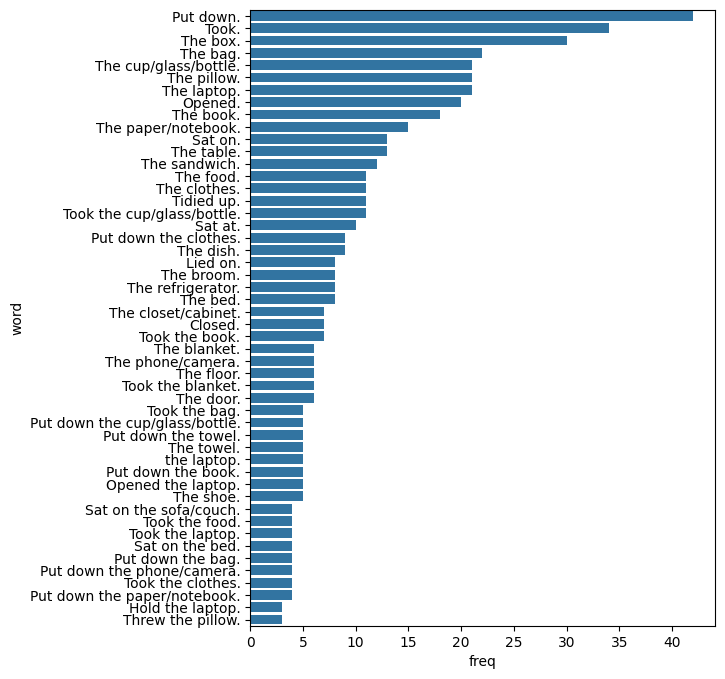

In [25]:
plt.figure(figsize=(6, 8))
sns.barplot(data=freq.sort_values('freq', ascending=False)[:50], x='freq', y='word')


Let's do some visualization also for the ground truth data

In [26]:
print(f"We have {gt_df['text'].nunique()} unique answers")


We have 198 unique answers


<Axes: xlabel='freq', ylabel='word'>

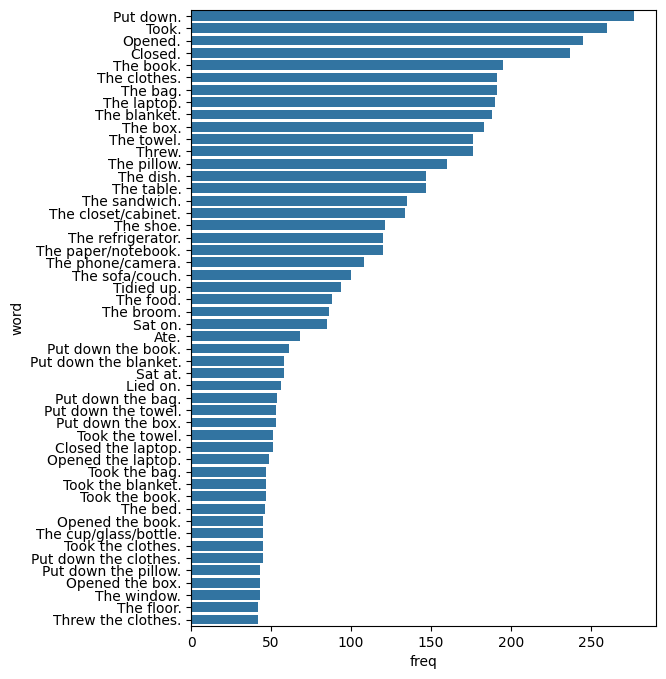

In [27]:
freq = gt_df['text'].value_counts().reset_index()
freq.columns = ['word', 'freq']

plt.figure(figsize=(6, 8))
sns.barplot(data=freq.sort_values('freq', ascending=False)[:50], x='freq', y='word')


In [28]:
# Inner join - keeps only indices present in both series

ans_df.rename(columns={'text': 'pred_text'}, inplace=True)
eval_df = gt_df.join(
    ans_df, 
    how='inner' # we account also for samples without answers
)

eval_df.shape


(663, 6)

In [29]:
def accuracy(eval_df, on_what='text'):
    hits_text = (eval_df[f'pred_{on_what}'].str.lower() == eval_df[on_what].str.lower()).sum()
    

    return hits_text/eval_df.shape[0]


In [30]:
def print_acc(eval_df, acc_fn):
    print(f"{'Question type':<15}{'Total':^15}{'Accuracy':^10}\n")

    total = eval_df.index.str.startswith('Interaction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Interaction')])
    print(f"{'Interaction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Sequence').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Sequence')])
    print(f"{'Sequence':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Prediction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Prediction')])
    print(f"{'Prediction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Feasibility').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Feasibility')])
    print(f"{'Feasibility':<15}{total:^15}{acc:^10.2%}")


In [31]:
print_acc(eval_df, lambda x: accuracy(x, on_what='text'))


Question type       Total      Accuracy 

Interaction          208        38.94%  
Sequence             339        43.95%  
Prediction           66         34.85%  
Feasibility          50         32.00%  


In [32]:
real_acc = accuracy(eval_df) * eval_df.shape[0] / gt_df.shape[0]

print(f"Real Accuracy: {real_acc:.2%}")


Real Accuracy: 3.79%


In [33]:
# % of answers conforming to template per category

def print_ans_perc(eval_df, gt_df):
    print(f"{'Question type':<15}{'Total':^15}{'Answered':^10}\n")

    total = gt_df.index.str.startswith('Interaction').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Interaction')].index))/total
    print(f"{'Interaction':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Sequence').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Sequence')].index))/total
    print(f"{'Sequence':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Prediction').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Prediction')].index))/total
    print(f"{'Prediction':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Feasibility').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Feasibility')].index))/total
    print(f"{'Feasibility':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.shape[0]
    acc = eval_df.shape[0]/total
    print(f"{'Overall':<15}{total:^15}{acc:^10.2%}")

print_ans_perc(eval_df, gt_df)


Question type       Total      Answered 

Interaction         2398        8.67%   
Sequence            3586        9.45%   
Prediction           624        10.58%  
Feasibility          490        10.20%  
Overall             7098        9.34%   


## Graph analysis

In [34]:
gen_graphs = []
with open(WORK_DIR / "data/datasets/STAR_QA_and_gen_stsg_p1.json", "r") as in_f:
    gen_graphs = json.load(in_f)

gen_graphs = {d['question_id']: d['stsg'] for d in gen_graphs}
gen_graphs_se = pd.Series(gen_graphs)
gen_graphs_se


Interaction_T2_3150    \nFrame 000019:\n\nwoman ---- lying_on ---- be...
Sequence_T1_5784       \nFrame 000223:\n\nwoman ---- sitting_on ---- ...
Interaction_T2_3935    \nFrame 000012:\n\nwoman ---- holding ---- car...
Sequence_T1_5311       \nFrame 000099:\n\nman ---- standing_in_front_...
Sequence_T1_2219       \nFrame 000011:\n\nwoman ---- sitting_on ---- ...
                                             ...                        
Prediction_T3_183      \nFrame 000376:\n\nman ---- holding ---- jar\n...
Prediction_T1_1161     \nFrame 000328:\n\nwoman ---- sitting_on ---- ...
Sequence_T4_2027       \nFrame 000757:\n\nwoman ---- holding_object -...
Interaction_T1_1301    \nFrame 000546:\n\nwall ---- supports ---- flo...
Sequence_T1_4963       \nFrame 000090:\n\nFrame 000147:\n\nFrame 0001...
Length: 774, dtype: object

In [35]:
print(gen_graphs_se.iloc[0])



Frame 000019:

woman ---- lying_on ---- bed
bed ---- containing ---- sheets
sheets ---- covering ---- mattress
bed ---- adjacent_to ---- bedside_table
bedside_table ---- supporting ---- lamp
lamp ---- having_shade ---- lampshade
lampshade ---- above ---- book
book ---- on_top_of ---- bedside_table
bed ---- adjacent_to ---- wall
wall ---- supporting ---- curtains
curtains ---- hanging_on ---- wall
bed ---- on_top_of ---- floor
floor ---- dark_color
bed ---- adjacent_to ---- woman
woman ---- lying_on ---- bed

Frame 000054:

woman ---- lying_on ---- bed
bed ---- containing ---- woman
bed ---- supporting ---- pillow
pillow ---- under ---- woman
bed ---- adjacent_to ---- nightstand
nightstand ---- holding ---- lamp
lamp ---- emitting_light_on ---- nightstand
nightstand ---- holding ---- books
books ---- stacked_on ---- nightstand
bed ---- against ---- wall
wall ---- supporting ---- bed
bed ---- adjacent_to ---- bookcase
bookcase ---- in_background ---- room
bed ---- on ---- floor
bed ----

In [36]:
def structure_stsg(g):
    sgs = g.split("Frame")

    sg_dict = {}
    for sg in sgs:
        sg = sg.strip()
        if sg != "":
            frame_id, val = [s.strip() for s in sg.split(":")]
            sg_dict[frame_id] = val

    new = {}
    for k, sg in sg_dict.items():
        string_triplets = [s.strip() for s in sg.split("\n")]
        triplets = []
        for triplet in string_triplets:
            triplets.append([s.strip() for s in re.split("-+", triplet)])
        new[k] = triplets

    return new
    
struct_gen_graphs = gen_graphs_se.apply(structure_stsg)


In [37]:
struct_gen_graphs.iloc[0]


{'000019': [['woman', 'lying_on', 'bed'],
  ['bed', 'containing', 'sheets'],
  ['sheets', 'covering', 'mattress'],
  ['bed', 'adjacent_to', 'bedside_table'],
  ['bedside_table', 'supporting', 'lamp'],
  ['lamp', 'having_shade', 'lampshade'],
  ['lampshade', 'above', 'book'],
  ['book', 'on_top_of', 'bedside_table'],
  ['bed', 'adjacent_to', 'wall'],
  ['wall', 'supporting', 'curtains'],
  ['curtains', 'hanging_on', 'wall'],
  ['bed', 'on_top_of', 'floor'],
  ['floor', 'dark_color'],
  ['bed', 'adjacent_to', 'woman'],
  ['woman', 'lying_on', 'bed']],
 '000054': [['woman', 'lying_on', 'bed'],
  ['bed', 'containing', 'woman'],
  ['bed', 'supporting', 'pillow'],
  ['pillow', 'under', 'woman'],
  ['bed', 'adjacent_to', 'nightstand'],
  ['nightstand', 'holding', 'lamp'],
  ['lamp', 'emitting_light_on', 'nightstand'],
  ['nightstand', 'holding', 'books'],
  ['books', 'stacked_on', 'nightstand'],
  ['bed', 'against', 'wall'],
  ['wall', 'supporting', 'bed'],
  ['bed', 'adjacent_to', 'bookcase'

In [38]:
STAR_data = []
with open(WORK_DIR / "data/datasets/STAR/STAR_annotations/STAR_val.json") as in_f:
    STAR_data = json.load(in_f)

STAR_data[0]


{'question_id': 'Interaction_T1_13',
 'question': 'Which object was tidied up by the person?',
 'video_id': '6H78U',
 'start': 11.1,
 'end': 19.6,
 'answer': 'The clothes.',
 'question_program': [{'function': 'Situations', 'value_input': []},
  {'function': 'Actions', 'value_input': []},
  {'function': 'Filter_Actions_with_Verb', 'value_input': ['tidy']},
  {'function': 'Unique', 'value_input': []},
  {'function': 'Query_Objs', 'value_input': []}],
 'choices': [{'choice_id': 0,
   'choice': 'The closet/cabinet.',
   'choice_program': [{'function': 'Equal',
     'value_input': ['closet/cabinet']}]},
  {'choice_id': 1,
   'choice': 'The blanket.',
   'choice_program': [{'function': 'Equal', 'value_input': ['blanket']}]},
  {'choice_id': 2,
   'choice': 'The clothes.',
   'choice_program': [{'function': 'Equal', 'value_input': ['clothes']}]},
  {'choice_id': 3,
   'choice': 'The table.',
   'choice_program': [{'function': 'Equal', 'value_input': ['table']}]}],
 'situations': {'000206': {'

In [49]:
def get_vocab_map(label_dir):
    vocab_map = dict()

    with open(label_dir) as in_file:
        for line in in_file.readlines():
            mapping = line.strip('\n')
            key, val = mapping.split(' ')
            vocab_map[key] = val
    
    return vocab_map

def textual_stsg(q_data):
    frame_ids = sorted(q_data['situations'].keys())

    stsg = {}
    for f in frame_ids:
        frame_sg = []
        rels = q_data['situations'][f]['rel_labels']
        
        for rel_pair, rel in zip(q_data['situations'][f]['rel_pairs'], rels):
            obj1, obj2 = rel_pair
            frame_sg.append([obj_vocab[obj1], rel_vocab[rel], obj_vocab[obj2]])

        stsg[f] = frame_sg
    
    return stsg


obj_vocab = get_vocab_map(WORK_DIR / 'data/datasets/STAR/STAR_annotations/class_maps/object_classes.txt')
rel_vocab = get_vocab_map(WORK_DIR /  'data/datasets/STAR/STAR_annotations/class_maps/relationship_classes.txt')


In [ ]:
textual_stsg(STAR_data[0])


{'000198': [['person', 'on_the_side_of', 'clothes']],
 '000202': [['person', 'in_front_of', 'clothes']],
 '000205': [['person', 'in_front_of', 'clothes'],
  ['person', 'in_front_of', 'blanket']],
 '000206': [['person', 'in_front_of', 'towel'],
  ['person', 'in_front_of', 'clothes'],
  ['person', 'in_front_of', 'blanket'],
  ['person', 'on_the_side_of', 'blanket']],
 '000212': [['person', 'on_the_side_of', 'towel'],
  ['person', 'in_front_of', 'towel'],
  ['person', 'in_front_of', 'clothes'],
  ['person', 'on_the_side_of', 'blanket']],
 '000217': [['person', 'in_front_of', 'towel'],
  ['person', 'on_the_side_of', 'clothes'],
  ['person', 'in_front_of', 'blanket'],
  ['person', 'on_the_side_of', 'blanket']],
 '000218': [['person', 'in_front_of', 'clothes'],
  ['person', 'in_front_of', 'blanket'],
  ['person', 'on_the_side_of', 'blanket']],
 '000221': [['person', 'in_front_of', 'towel'],
  ['person', 'in_front_of', 'clothes'],
  ['person', 'in_front_of', 'blanket']],
 '000223': [['person'

In [56]:
gt_stsg = {}
for situation in STAR_data:
    gt_stsg[situation['question_id']] = textual_stsg(situation)

gt_stsg_se = pd.Series(gt_stsg)


In [55]:
test_id = struct_gen_graphs.index[0]
test_id


'Interaction_T2_3150'

In [57]:
struct_gen_graphs[test_id]


{'000019': [['woman', 'lying_on', 'bed'],
  ['bed', 'containing', 'sheets'],
  ['sheets', 'covering', 'mattress'],
  ['bed', 'adjacent_to', 'bedside_table'],
  ['bedside_table', 'supporting', 'lamp'],
  ['lamp', 'having_shade', 'lampshade'],
  ['lampshade', 'above', 'book'],
  ['book', 'on_top_of', 'bedside_table'],
  ['bed', 'adjacent_to', 'wall'],
  ['wall', 'supporting', 'curtains'],
  ['curtains', 'hanging_on', 'wall'],
  ['bed', 'on_top_of', 'floor'],
  ['floor', 'dark_color'],
  ['bed', 'adjacent_to', 'woman'],
  ['woman', 'lying_on', 'bed']],
 '000054': [['woman', 'lying_on', 'bed'],
  ['bed', 'containing', 'woman'],
  ['bed', 'supporting', 'pillow'],
  ['pillow', 'under', 'woman'],
  ['bed', 'adjacent_to', 'nightstand'],
  ['nightstand', 'holding', 'lamp'],
  ['lamp', 'emitting_light_on', 'nightstand'],
  ['nightstand', 'holding', 'books'],
  ['books', 'stacked_on', 'nightstand'],
  ['bed', 'against', 'wall'],
  ['wall', 'supporting', 'bed'],
  ['bed', 'adjacent_to', 'bookcase'

In [58]:
gt_stsg_se[test_id]


{'000019': [['person', 'lying_on', 'bed'],
  ['person', 'above', 'bed'],
  ['person', 'behind', 'bed']],
 '000027': [['person', 'lying_on', 'bed'],
  ['person', 'above', 'bed'],
  ['person', 'behind', 'bed']],
 '000054': [['person', 'lying_on', 'bed'],
  ['person', 'on_the_side_of', 'bed'],
  ['person', 'above', 'bed']],
 '000079': [['person', 'sitting_on', 'bed'],
  ['person', 'on_the_side_of', 'bed'],
  ['person', 'above', 'bed']],
 '000089': [['person', 'sitting_on', 'bed'],
  ['person', 'touching', 'bed'],
  ['person', 'beneath', 'bed'],
  ['person', 'on_the_side_of', 'bed']],
 '000124': [['person', 'sitting_on', 'bed'],
  ['person', 'beneath', 'bed'],
  ['person', 'on_the_side_of', 'bed']],
 '000127': [['person', 'sitting_on', 'bed'],
  ['person', 'beneath', 'bed'],
  ['person', 'on_the_side_of', 'bed']],
 '000131': [['person', 'sitting_on', 'bed'],
  ['person', 'beneath', 'bed'],
  ['person', 'on_the_side_of', 'bed']],
 '000159': [['person', 'sitting_on', 'bed'],
  ['person', 'be